## Regression: Predict fuel efficiency

根据车的特征，预测 MPG (Miles Per Gallon), 即预测燃油效率(可以应用在二手车市场)。

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.__version__

'2.0.0-alpha0'

### 下载数据集

使用 keras 的 get_file 可以来下载数据集。Keras 默认下载的数据集存放在 `~/.keras/` 目录下。


In [17]:
dataset_path = keras.utils.get_file(
    'auto-mpg.data',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
)

In [18]:
col_names = [
    'MPG', 'Cylinders', 'Displacement', 'Horsepower',
    'Weight', 'Acceleration', 'Model Year', 'Origin'
]

raw_dataset = pd.read_csv(
    dataset_path, 
    names = col_names,
    na_values = '?',
    comment = '\t',
    sep = ' ',
    skipinitialspace = True
)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data, 数据清洗

1. 数据集包含一些 nan 的值。我们需要对他们做下处理, 直接删除就好了。

In [19]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [20]:
dataset = dataset.dropna()

2. "Origin" 产地是一个分类属性，而不是一个连续值。所以我们可以对其用『独热编码』(one-hot encoding).

In [21]:
origin = dataset.pop('Origin')

In [23]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
388,26.0,4,156.0,92.0,2585.0,14.5,82,1.0,0.0,0.0
389,22.0,6,232.0,112.0,2835.0,14.7,82,1.0,0.0,0.0
390,32.0,4,144.0,96.0,2665.0,13.9,82,0.0,0.0,1.0
391,36.0,4,135.0,84.0,2370.0,13.0,82,1.0,0.0,0.0
392,27.0,4,151.0,90.0,2950.0,17.3,82,1.0,0.0,0.0
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 将数据集划分成训练和测试集

In [24]:
train_dataset = dataset.sample(frac=0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

### Have a look of our data

我们可以看一下相应某些行的联合分布 (joint distribution)。 什么是 Joint distribution 那?

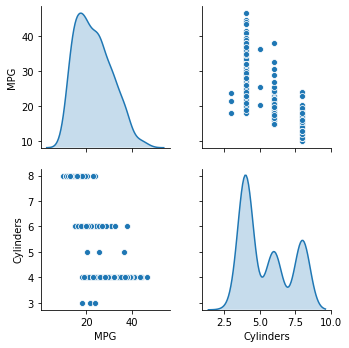

In [28]:
sns.pairplot(
    train_dataset[['MPG', 'Cylinders']], 
    diag_kind='kde'
)

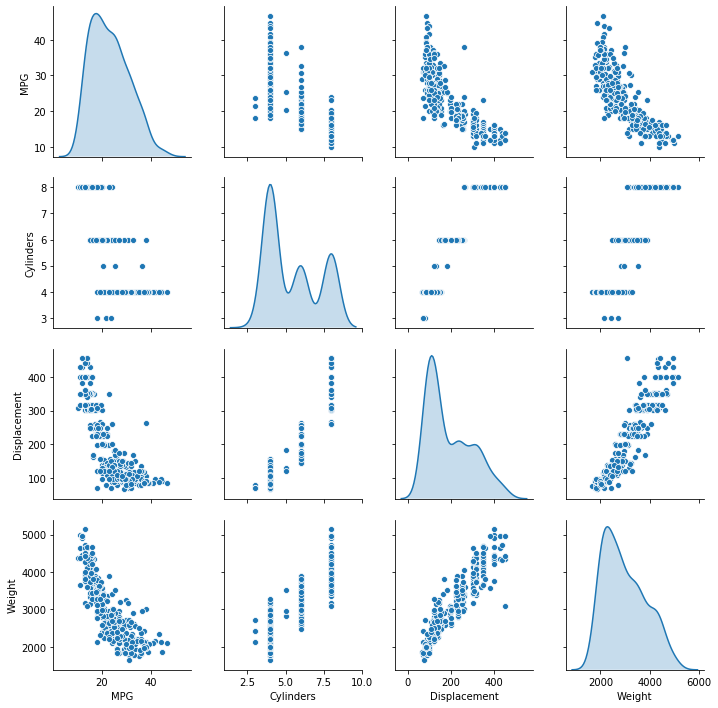

In [29]:
sns.pairplot(
    train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], 
    diag_kind='kde'
)

查看一下数据集的统计信息

In [32]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 从特征中分离出标签

In [34]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 数据规范化

从上面的 `train_stats` 可以看出每一个特征的取值范围都不在一个量级上。为了加速模型的收敛，我们还需要对数据进行规范化处理。

**注意**: 数据规范化用到的基准是训练数据。测试数据也需要使用这个基准来进行规范化处理。

In [36]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


### 构建模型

In [45]:
def build_model():
    model = keras.Sequential([
        layers.Dense(
            64, 
            activation=tf.nn.relu, 
            input_shape=[len(train_dataset.keys())]
        ),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.optimizers.RMSprop(0.001)
    
    model.compile(
        loss = 'mean_squared_error',
        optimizer = optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    
    return model

In [46]:
model = build_model()

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### 模型训练

In [50]:
# Display training progress by printing a single dot for
# each completed epoch.

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 : print(' ')
        print('.', end='')

In [51]:
EPOCHS = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split = 0.2,
    verbose = 0,
    callbacks = [PrintDot()]
)

 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

### 训练过程可视化

In [52]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.316450,1.004045,2.316450,10.077355,2.492048,10.077355,995
996,2.668119,1.105306,2.668119,9.946813,2.376115,9.946814,996
997,2.266711,0.976317,2.266711,9.908430,2.462898,9.908430,997
998,2.432885,0.983013,2.432885,10.025055,2.455786,10.025056,998
999,2.503320,1.016282,2.503320,9.751115,2.359424,9.751115,999


In [59]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    # Mean Abs Error [MPG]
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(
        hist['epoch'],
        hist['mean_absolute_error'],
        label='Train Error'
    )
    plt.plot(
        hist['epoch'],
        hist['val_mean_absolute_error'],
        label='Val Error'
    )
    plt.ylim([0, 5]) # set the y-limits of the current axes.
    plt.legend()
    
    # Mean Abs Error [MPG^2]
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$MPG^2$]')
    plt.plot(
        hist['epoch'],
        hist['mean_squared_error'],
        label='Train Error'
    )
    plt.plot(
        hist['epoch'],
        hist['val_mean_squared_error'],
        label='Val Error'
    )
    plt.ylim([0, 20])
    plt.legend()
    
    plt.show()

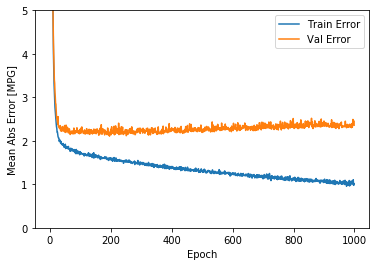

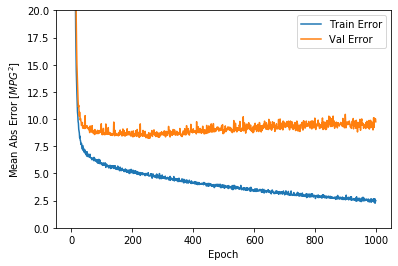

In [60]:
plot_history(history)

#### Early Stopping

从上面的图像可以看到，模型在 100 次迭代后验证误差反而增加了。这就出现了过拟合的状态。我们可以使用 EarlyStopping 的策略在发现验证误差无法优化后就终止训练。

[EarlyStopping Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) 相关文档。

In [64]:
model = build_model()

# The patience parameter is the amount of epochs to check
# for improvement
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split = 0.2,
    verbose = 0,
    callbacks = [early_stop, PrintDot()]
)


 
........................................................

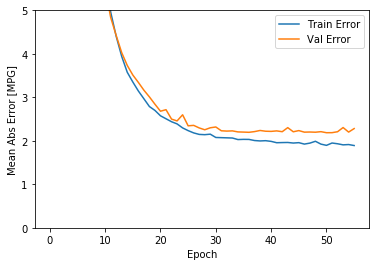

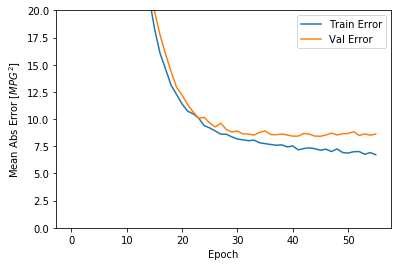

In [65]:
plot_history(history)

### 测试集上验证及预测

In [66]:
loss, mae, mse = model.evaluate(
    normed_test_data,
    test_labels,
    verbose = 0
)

print("Testing set Mean Abs Error:{:5.2f} MPG".format(mae))

Testing set Mean Abs Error: 1.79 MPG


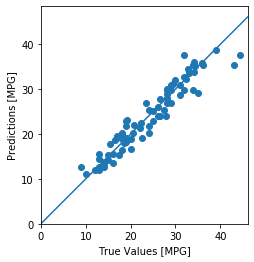

In [67]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

可以看到真实值和预测值在对角线汇聚，说明我们的模型还不错。

#### 误判分布

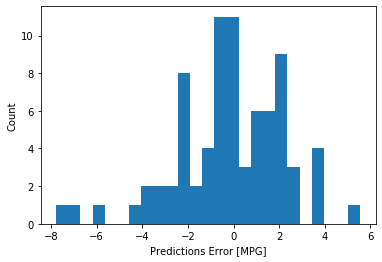

In [70]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Predictions Error [MPG]')
_ = plt.ylabel('Count')

从误差分布的图像来看，好像并不是我们期望的高斯分布。不过这可能是因为
我们的测试样本过少而已。大样本后肯定是高斯分布。

### 总结

- Mean Squared Erro(MSE)， 是回归问题最常用的损失函数。
- Mean Absolute Error(MAE), 是回归问题最常用的 Metric.
- 样本中的特征需要清洗，规范化处理。
- 当样本不够时，不要用太复杂的模型。否则过拟合。
- Early Stopping 是防止过拟合的一种方法。